In [8]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"

Cloning into 'deepflows'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 40 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp36-none-any.whl size=1121 sha256=591380948543c5226be05fbb45c5ee44877d919d74a8c08fd56723d971eea99f
  Stored in directory: /tmp/pip-ephem-wheel-cache-wntuswgr/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc
  Found existing installation: recurrent-flows-msc 0.1.0
    Uninstalling recurrent-flows-msc-0.1.0:
      Successfully uninstalled recurrent-flows-msc-0.1.0


In [1]:
import torch
import torch.optim as optim
import torch.utils.data as Data  
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as td
import numpy as np
from tqdm.notebook import trange, tqdm
import torchvision

from deepflows import utils
from deepflows import plot_tools
from deepflows.data_generators.halfmoon import * 

In [2]:
device=utils.set_gpu(True)
train_data, train_labels, test_data, test_labels=sample_half_moons(n_train=2000, n_test=1000)
train_loader, test_loader = loader_half_moons(train_data, test_data, 64)

Note: GPU is available


In [3]:
def train(model, train_loader, optimizer):
  losses = []
  model.train()
  for x in train_loader:
    x = x.to(device).float()
    loss = model.nll(x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
  return losses

def evaluate(model, validation_loader):
  model.eval()
  total_loss=0
  n = len(validation_loader.dataset)
  with torch.no_grad():
    for x in validation_loader:
      x = x.to(device).float()
      loss = model.nll(x)
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / n
  return avg_loss.item()

def run_model(model, train_loader, validation_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, test_losses = [], []
    
    #Init loss:
    test_loss = evaluate(model, validation_loader)
    test_losses.append(test_loss)  

    for epoch in tqdm(range(epochs), desc='Epoch', leave=False):
        model.train()
        epoch_train_losses = train(model, train_loader, optimizer) 
        train_losses.extend(epoch_train_losses)

        test_loss = evaluate(model, validation_loader)
        test_losses.append(test_loss)
            
    return train_losses, test_losses

class MLP(nn.Module):
    def __init__(self, input_dim, n_layers, hidden_dim, output_dim):
        super(MLP, self).__init__()
        layers = []
        for _ in range(n_layers):
          layers.append(nn.Linear(input_dim, hidden_dim))
          layers.append(nn.ReLU())
          input_dim = hidden_dim
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
      return self.layers(x)

## Autoregressive Model

In [4]:
'''
Here we make the mixtures
https://en.wikipedia.org/wiki/Mixture_model
[Batch_size, n_component, loc]
'''
class MixtureCDF(nn.Module):
    def __init__(self, n_components):
        super(MixtureCDF, self).__init__()
        self.loc = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_scale = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.weight_logits = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.n_components = n_components

    def flow(self, x):
        weights = F.softmax(self.weight_logits, dim=0).unsqueeze(0).repeat(x.shape[0], 1)
        # cdf of x
        z = (td.Normal(self.loc, self.log_scale.exp()).cdf(
            x.unsqueeze(1).repeat(1, self.n_components))*weights).sum(dim=1)
        # log_det = log dz/dx = log pdf(x)
        log_det = (td.Normal(self.loc, self.log_scale.exp()).log_prob(
            x.unsqueeze(1).repeat(1, self.n_components)).exp()*weights).sum(dim=1).log()
        return z, log_det

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return td.Uniform(0.0, 1.0).log_prob(z) + log_det
 
    # Compute loss as negative log-likelihood
    def nll(self, x):
        return -self.log_prob(x).mean()

class AutoregFlow(nn.Module):
    def __init__(self):
        super(AutoregFlow, self).__init__()
        self.components = 5
        self.dim1_flow = MixtureCDF(n_components=self.components).to(device)
        self.mlp = MLP(1, 3, 64, self.components * 3).to(device)

    def flow(self, x):
      #split into chunks
      x1, x2 = torch.chunk(x, 2, dim=1)

      #Dimension 1, x1, find parameters
      z1, log_det1 = self.dim1_flow.flow(x1.squeeze())
      loc, log_scale, weight_logits = torch.chunk(self.mlp(x1), 3, dim=1)
      
      #Use parameters to generate z2
      weights = F.softmax(weight_logits, dim=1)
      z2 = (td.Normal(loc, log_scale.exp()).cdf(
            x2.repeat(1, self.components)) * weights).sum(dim=1)
      log_det2 = (td.Normal(loc, log_scale.exp()).log_prob(
          x2.repeat(1, self.components)).exp() * weights).sum(dim=1).log()
      
      #return z1/z2 and the determinant for the log_prob function
      return (torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1), 
       torch.cat([log_det1.unsqueeze(1), log_det2.unsqueeze(1)], dim=1))

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return (td.Uniform(utils.tensor(0.0), utils.tensor(1.0)).log_prob(z) + log_det).mean(dim=1) # shape: [batch_size, dim]

    def nll(self, x):
      return - self.log_prob(x).mean()

In [5]:
ar_flow = AutoregFlow()
train_losses, test_losses = run_model(ar_flow, train_loader, test_loader, dict(epochs=100, lr=5e-3))

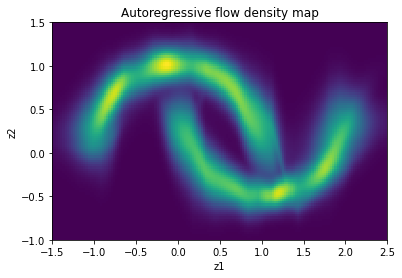

In [6]:
plot_tools.show_2d_heatmap(ar_flow.log_prob, device, title="Autoregressive flow density map")

## RealNVP Flow

In [7]:
class AffineCoupling(nn.Module):
    def __init__(self, type, n_layers=2, hidden_dim=64):
        super(AffineCoupling, self).__init__()
        self.mask = self.create_mask(type=type)
        self.mlp = MLP(input_dim=2, n_layers=n_layers, hidden_dim=hidden_dim, output_dim=2).to(device)
    
    def create_mask(self, type):
      if type == "x_dim":
        mask = torch.FloatTensor([1.0, 0.0]).to(device)
      elif type == "y_dim":
        mask = torch.FloatTensor([0.0, 1.0]).to(device)
      else:
        print("Wrong type")
      return mask

    def forward(self, x, reverse=False):
        batch_size = x.shape[0]
        b = self.mask.repeat(batch_size, 1)
        x_mask = x * b
        output=self.mlp(x_mask)

        log_s, t = output.split(1, dim=1)

        t = t * (1.0 - b)
        log_s = log_s * (1.0 - b)

        if reverse:
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

class RealNVP(nn.Module):
    def __init__(self, 
                 transforms):
        super().__init__()

        self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
        self.transforms = nn.ModuleList(transforms)
    
    def flow(self, x): #f
        # maps x -> z
        z, log_det = x, torch.zeros_like(x)
        for op in self.transforms:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        return z, log_det

    def invert_flow(self, z): #g
        # z -> x (inverse of f)
        for op in reversed(self.transforms):
            z, _ = op.forward(z, reverse=True)
        return z

    def log_prob(self, x):
        z, log_det = self.flow(x)
        return torch.sum(log_det, dim=1) + torch.sum(self.prior.log_prob(z), dim=1)

    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 2])
        return self.invert_flow(z)

    def nll(self, x):
        return - self.log_prob(x).mean()

In [8]:
RNVP_flow = RealNVP([AffineCoupling("y_dim", n_layers=2, hidden_dim=64),
                    AffineCoupling("x_dim", n_layers=2, hidden_dim=64),
                    AffineCoupling("y_dim", n_layers=2, hidden_dim=64),
                    AffineCoupling("x_dim", n_layers=2, hidden_dim=64),
                    AffineCoupling("y_dim", n_layers=2, hidden_dim=64),
                    AffineCoupling("x_dim", n_layers=2, hidden_dim=64)])
train_losses, test_losses = run_model(RNVP_flow, train_loader, test_loader, dict(epochs=200, lr=5e-3))

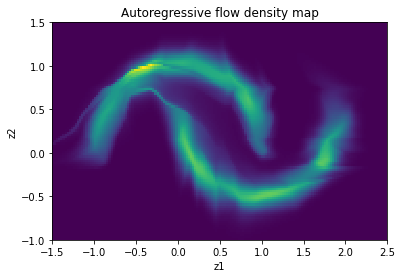

In [9]:
plot_tools.show_2d_heatmap(RNVP_flow.log_prob, device, title="Autoregressive flow density map")

Conditional RealNVP Flow